In [1]:
import pandas as pd

import torch as th
import torch.nn.functional as F

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

device = th.device('cpu')

### Importing data

In [2]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
print('Train shape:', df_train.shape)
print('Test shape:', df_test.shape)

Train shape: (42000, 785)
Test shape: (28000, 784)


In [4]:
df_train['label'].value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

### Splitting data into features and labels
x = features

y = labels

In [5]:
x = df_train[df_train.columns[1:]].values
y = df_train['label'].values

x_to_submit = df_test[df_train.columns[1:]].values

### Reshaping features to transform it to a 28x28 image

In [6]:
x = np.reshape(x, (x.shape[0], 28, 28))
x_to_submit = np.reshape(x_to_submit, (x_to_submit.shape[0], 28, 28))

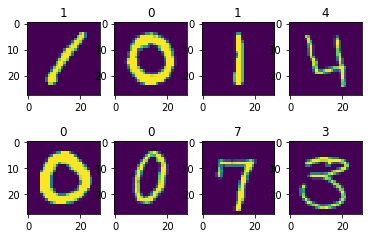

In [7]:
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x[i])
    plt.title(y[i])

### Splitting data for training, testing and validation

In [8]:
x_train, x_test_val, y_train, y_test_val = train_test_split(x, y, test_size = .15, 
                                                            stratify=y, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test_val, y_test_val, test_size = .25, 
                                                stratify=y_test_val, random_state=42)

print('X train shape:', x_train.shape)
print('Y train shape:', y_train.shape)
print()
print('X test shape:', x_test.shape)
print('Y test shape:', y_test.shape)
print()
print('X validation shape:', x_val.shape)
print('Y validation shape:', y_val.shape)

X train shape: (35700, 28, 28)
Y train shape: (35700,)

X test shape: (4725, 28, 28)
Y test shape: (4725,)

X validation shape: (1575, 28, 28)
Y validation shape: (1575,)


### Transforming data to tensor

Now we have (batch, height, width) features.

First we will need to add the channel dimension with numpy's expand_dims, now having features with shape of (batch, height, width, channel).

Tensors needs to have shape of (batch, channel, height, width), so we will transpose our data.

In [9]:
def img2tensor(arr, device):
    arr_expand = np.expand_dims(arr, 3)
    arr_transpose = np.transpose(arr_expand, (0, 3, 1, 2))
    tensor = th.from_numpy(arr_transpose).to(device)
    
    return tensor.float()

x_train = img2tensor(x_train, device)
x_test = img2tensor(x_test, device)
x_val = img2tensor(x_val, device)

x_to_submit = img2tensor(x_to_submit, device)

y_train = th.from_numpy(y_train).to(device)
y_test = th.from_numpy(y_test).to(device)
y_val = th.from_numpy(y_val).to(device)

### Creating a DataLoader

In [10]:
dataset = th.utils.data.TensorDataset(x_train, y_train)

data_loader = th.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)

### Creating our Convolutional neural network

In [11]:
class CNN(th.nn.Module):
    
    def __init__(self, hidden_size, droupout_p, output_size):
        super(CNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.droupout_p = droupout_p
        self.output_size = output_size
        
        self.norm = th.nn.BatchNorm2d(1)
        
        self.conv1 = th.nn.Conv2d(1, 16, (3, 3))
        self.conv2 = th.nn.Conv2d(16, 32, (4, 4))
        
        self.dropout = th.nn.Dropout(self.droupout_p)
        
        self.fc1 = th.nn.Linear(32*5*5, self.hidden_size)
        self.fc2 = th.nn.Linear(self.hidden_size, self.output_size)
        
        
    def forward(self, x):
        out = self.norm(x)
        
        out = F.relu(self.conv1(out))
        out = F.max_pool2d(out, (2, 2))
        
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, (2, 2))
        
        out = out.view(-1, 32*5*5)
        
        out = F.tanh(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out
    
    def predict(self, x):
        out = self.forward(x)
        _, y_pred = th.max(out, 1)
    
        return y_pred

Decay the learning rate by 10 every 30 epochs

In [12]:
def decrease_lr(opt, epoch, init_lr):
    lr =  init_lr * (0.1 ** (epoch // 30))
    for param_group in opt.param_groups:
        param_group['lr'] = lr

In [13]:
lr = 0.001
epochs = 90

net = CNN(hidden_size=32, droupout_p=.3, output_size=10).to(device)

opt = th.optim.Adam(net.parameters(), lr)
criterion = th.nn.CrossEntropyLoss()

### Training our net

In [14]:
losses = []
test_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    print('Epoch:', epoch+1)
    
    decrease_lr(opt, epoch, lr)
    
    net.train()
    batch_losses = []
    for feats, labels in tqdm(data_loader):      
        output = net(feats)
        
        loss = criterion(output, labels)
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        batch_losses.append(loss.item())
    
    net.eval()
    
    loss_mean = np.array(batch_losses).mean()
    test_acc = accuracy_score(y_test, net.predict(x_test).data.numpy())
    val_acc = accuracy_score(y_val, net.predict(x_val).data.numpy())
    
    losses.append(loss_mean)
    test_accuracies.append(test_acc)
    val_accuracies.append(val_acc)
    
    print('Loss:', loss_mean)
    print('Test acc:', test_acc)
    print('Validation acc:', val_acc)

Epoch: 1



Loss: 0.43593408649458604
Test acc: 0.9695238095238096
Validation acc: 0.9701587301587301
Epoch: 2



Loss: 0.11181060847218464
Test acc: 0.979047619047619
Validation acc: 0.9828571428571429
Epoch: 3



Loss: 0.0737438821429465
Test acc: 0.9845502645502645
Validation acc: 0.9885714285714285
Epoch: 4



Loss: 0.05549108973477317
Test acc: 0.9870899470899471
Validation acc: 0.9898412698412699
Epoch: 5



Loss: 0.0431732374441703
Test acc: 0.9856084656084656
Validation acc: 0.9866666666666667
Epoch: 6



Loss: 0.03738991028944902
Test acc: 0.9875132275132276
Validation acc: 0.9885714285714285
Epoch: 7



Loss: 0.029226710488993664
Test acc: 0.9851851851851852
Validation acc: 0.9898412698412699
Epoch: 8



Loss: 0.026904203133991493
Test acc: 0.9881481481481481
Validation acc: 0.9879365079365079
Epoch: 9



Loss: 0.023456166635648312
Test acc: 0.9873015873015873
Validation acc: 0.9892063492063492
Epoch: 10



Loss: 0.02188321277603549
Test acc: 0.9866666666666667
Validation acc: 0.9873015873015873
Epoch: 11



Loss: 0.01991291741836628
Test acc: 0.9879365079365079
Validation acc: 0.9898412698412699
Epoch: 12



Loss: 0.016171020253154474
Test acc: 0.9864550264550265
Validation acc: 0.9873015873015873
Epoch: 13



Loss: 0.01552374265319733
Test acc: 0.9879365079365079
Validation acc: 0.9866666666666667
Epoch: 14



Loss: 0.015238022915490692
Test acc: 0.9873015873015873
Validation acc: 0.9898412698412699
Epoch: 15



Loss: 0.012648593437895752
Test acc: 0.9887830687830688
Validation acc: 0.9892063492063492
Epoch: 16



Loss: 0.012663677500277831
Test acc: 0.9877248677248677
Validation acc: 0.9892063492063492
Epoch: 17



Loss: 0.010913520357969376
Test acc: 0.9885714285714285
Validation acc: 0.9911111111111112
Epoch: 18



Loss: 0.013099937565466232
Test acc: 0.988994708994709
Validation acc: 0.9892063492063492
Epoch: 19



Loss: 0.011825030113580827
Test acc: 0.9892063492063492
Validation acc: 0.9885714285714285
Epoch: 20



Loss: 0.009907920323103583
Test acc: 0.9902645502645503
Validation acc: 0.9898412698412699
Epoch: 21



Loss: 0.00886018573760912
Test acc: 0.9881481481481481
Validation acc: 0.9885714285714285
Epoch: 22



Loss: 0.007678113415495216
Test acc: 0.9883597883597883
Validation acc: 0.9892063492063492
Epoch: 23



Loss: 0.007605594946531297
Test acc: 0.9885714285714285
Validation acc: 0.9911111111111112
Epoch: 24



Loss: 0.008822734996608617
Test acc: 0.9864550264550265
Validation acc: 0.9873015873015873
Epoch: 25



Loss: 0.008706425043813954
Test acc: 0.9866666666666667
Validation acc: 0.9892063492063492
Epoch: 26



Loss: 0.006224174304628557
Test acc: 0.9892063492063492
Validation acc: 0.9917460317460317
Epoch: 27



Loss: 0.0064399331630043246
Test acc: 0.9894179894179894
Validation acc: 0.9898412698412699
Epoch: 28



Loss: 0.005676308768532853
Test acc: 0.9868783068783069
Validation acc: 0.9917460317460317
Epoch: 29



Loss: 0.008676982706827464
Test acc: 0.9868783068783069
Validation acc: 0.9873015873015873
Epoch: 30



Loss: 0.006686642886082712
Test acc: 0.9892063492063492
Validation acc: 0.9892063492063492
Epoch: 31



Loss: 0.0032931121047625332
Test acc: 0.9896296296296296
Validation acc: 0.9904761904761905
Epoch: 32



Loss: 0.0027270285569886933
Test acc: 0.9896296296296296
Validation acc: 0.9904761904761905
Epoch: 33



Loss: 0.0024668943321254724
Test acc: 0.9898412698412699
Validation acc: 0.9904761904761905
Epoch: 34



Loss: 0.0025377909594232737
Test acc: 0.9896296296296296
Validation acc: 0.9911111111111112
Epoch: 35



Loss: 0.0022899408557182257
Test acc: 0.9894179894179894
Validation acc: 0.9911111111111112
Epoch: 36



Loss: 0.001926906679860311
Test acc: 0.9898412698412699
Validation acc: 0.9898412698412699
Epoch: 37



Loss: 0.0019018301652325056
Test acc: 0.9902645502645503
Validation acc: 0.9898412698412699
Epoch: 38



Loss: 0.001942039653247174
Test acc: 0.9902645502645503
Validation acc: 0.9904761904761905
Epoch: 39



Loss: 0.0014981896329169125
Test acc: 0.9906878306878307
Validation acc: 0.9923809523809524
Epoch: 40



Loss: 0.002032178982494579
Test acc: 0.9906878306878307
Validation acc: 0.9904761904761905
Epoch: 41



Loss: 0.0015226925028227491
Test acc: 0.9902645502645503
Validation acc: 0.9904761904761905
Epoch: 42



Loss: 0.0016608270492755412
Test acc: 0.9902645502645503
Validation acc: 0.9904761904761905
Epoch: 43



Loss: 0.0017535686020899814
Test acc: 0.9898412698412699
Validation acc: 0.9923809523809524
Epoch: 44



Loss: 0.001764722294786375
Test acc: 0.990899470899471
Validation acc: 0.9898412698412699
Epoch: 45



Loss: 0.0013898793574607167
Test acc: 0.990899470899471
Validation acc: 0.9917460317460317
Epoch: 46



Loss: 0.0012126084018475995
Test acc: 0.9904761904761905
Validation acc: 0.9904761904761905
Epoch: 47



Loss: 0.0014133373548828473
Test acc: 0.9902645502645503
Validation acc: 0.9911111111111112
Epoch: 48



Loss: 0.0014347578017557946
Test acc: 0.990899470899471
Validation acc: 0.9911111111111112
Epoch: 49



Loss: 0.0011514049567996263
Test acc: 0.9902645502645503
Validation acc: 0.9923809523809524
Epoch: 50



Loss: 0.0011484102737498488
Test acc: 0.9902645502645503
Validation acc: 0.9904761904761905
Epoch: 51



Loss: 0.001538590214807323
Test acc: 0.9904761904761905
Validation acc: 0.9917460317460317
Epoch: 52



Loss: 0.0012385781499825734
Test acc: 0.9898412698412699
Validation acc: 0.9911111111111112
Epoch: 53



Loss: 0.0010593563326466039
Test acc: 0.9906878306878307
Validation acc: 0.9904761904761905
Epoch: 54



Loss: 0.001032279910043949
Test acc: 0.9898412698412699
Validation acc: 0.9911111111111112
Epoch: 55



Loss: 0.0013135523058685045
Test acc: 0.9898412698412699
Validation acc: 0.9898412698412699
Epoch: 56



Loss: 0.0011435074685789556
Test acc: 0.9900529100529101
Validation acc: 0.9923809523809524
Epoch: 57



Loss: 0.0012812852453745244
Test acc: 0.9902645502645503
Validation acc: 0.9917460317460317
Epoch: 58



Loss: 0.0010742102983057208
Test acc: 0.9902645502645503
Validation acc: 0.9923809523809524
Epoch: 59



Loss: 0.0011370145282048585
Test acc: 0.9904761904761905
Validation acc: 0.9892063492063492
Epoch: 60



Loss: 0.001083848975388971
Test acc: 0.9904761904761905
Validation acc: 0.9904761904761905
Epoch: 61



Loss: 0.0009850197201143071
Test acc: 0.9904761904761905
Validation acc: 0.9904761904761905
Epoch: 62



Loss: 0.0009955802481058258
Test acc: 0.9904761904761905
Validation acc: 0.9904761904761905
Epoch: 63



Loss: 0.0012918265994038356
Test acc: 0.9904761904761905
Validation acc: 0.9904761904761905
Epoch: 64



Loss: 0.0011922116571425425
Test acc: 0.9911111111111112
Validation acc: 0.9911111111111112
Epoch: 65



Loss: 0.0008095781202743945
Test acc: 0.990899470899471
Validation acc: 0.9904761904761905
Epoch: 66



Loss: 0.0011446457447928276
Test acc: 0.9911111111111112
Validation acc: 0.9904761904761905
Epoch: 67



Loss: 0.0011283270060969289
Test acc: 0.9913227513227513
Validation acc: 0.9898412698412699
Epoch: 68



Loss: 0.001070179343901846
Test acc: 0.9911111111111112
Validation acc: 0.9898412698412699
Epoch: 69



Loss: 0.0009674017985687015
Test acc: 0.9904761904761905
Validation acc: 0.9904761904761905
Epoch: 70



Loss: 0.000815125991787526
Test acc: 0.9904761904761905
Validation acc: 0.9911111111111112
Epoch: 71



Loss: 0.0010175677392760495
Test acc: 0.990899470899471
Validation acc: 0.9898412698412699
Epoch: 72



Loss: 0.0008287448318220587
Test acc: 0.990899470899471
Validation acc: 0.9904761904761905
Epoch: 73



Loss: 0.0009529141521032251
Test acc: 0.9906878306878307
Validation acc: 0.9904761904761905
Epoch: 74



Loss: 0.0008265350515299075
Test acc: 0.9906878306878307
Validation acc: 0.9911111111111112
Epoch: 75



Loss: 0.000874097560586115
Test acc: 0.990899470899471
Validation acc: 0.9911111111111112
Epoch: 76



Loss: 0.0008881852725210615
Test acc: 0.9906878306878307
Validation acc: 0.9904761904761905
Epoch: 77



Loss: 0.0008570712249848668
Test acc: 0.9904761904761905
Validation acc: 0.9911111111111112
Epoch: 78



Loss: 0.0009652653273963957
Test acc: 0.9904761904761905
Validation acc: 0.9911111111111112
Epoch: 79



Loss: 0.0010374469401278005
Test acc: 0.990899470899471
Validation acc: 0.9898412698412699
Epoch: 80



Loss: 0.0008911186401741722
Test acc: 0.990899470899471
Validation acc: 0.9898412698412699
Epoch: 81



Loss: 0.0008555817427960272
Test acc: 0.990899470899471
Validation acc: 0.9898412698412699
Epoch: 82



Loss: 0.0008833481465126042
Test acc: 0.990899470899471
Validation acc: 0.9898412698412699
Epoch: 83



Loss: 0.0010105591155283322
Test acc: 0.9911111111111112
Validation acc: 0.9898412698412699
Epoch: 84



Loss: 0.0008261016270097104
Test acc: 0.9911111111111112
Validation acc: 0.9904761904761905
Epoch: 85



Loss: 0.0009026845783978069
Test acc: 0.990899470899471
Validation acc: 0.9904761904761905
Epoch: 86



Loss: 0.0008051581266330436
Test acc: 0.9911111111111112
Validation acc: 0.9904761904761905
Epoch: 87



Loss: 0.0009459857856633053
Test acc: 0.9906878306878307
Validation acc: 0.9904761904761905
Epoch: 88



Loss: 0.001021964309795946
Test acc: 0.9906878306878307
Validation acc: 0.9904761904761905
Epoch: 89



Loss: 0.0009228218976469467
Test acc: 0.9906878306878307
Validation acc: 0.9898412698412699
Epoch: 90



Loss: 0.0008920073087312671
Test acc: 0.9904761904761905
Validation acc: 0.9898412698412699


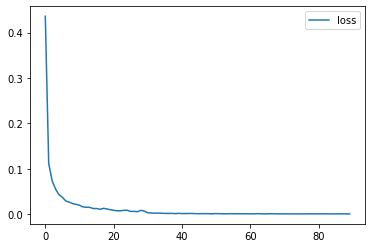

In [15]:
plt.plot(losses, label='loss')
plt.legend()

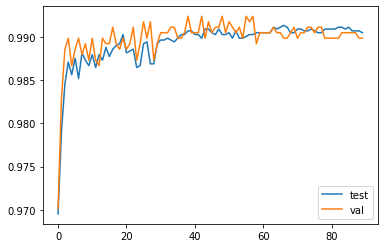

In [16]:
plt.plot(test_accuracies, label='test')
plt.plot(val_accuracies, label='val')
plt.legend()

In [17]:
th.save(net.state_dict(), 'model-mnist.pth.tar')

In [18]:
def plot_confusion_matrix(cm, title):
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True')
    plt.xlabel('Predicted')

[[463   0   0   0   0   0   1   0   0   1]
 [  0 523   2   1   0   0   0   1   0   0]
 [  0   0 470   0   0   0   0   0   0   0]
 [  1   0   0 484   0   1   0   1   1   2]
 [  0   2   0   0 452   0   0   0   0   4]
 [  0   0   0   3   0 419   1   0   4   0]
 [  0   0   0   0   0   0 465   0   0   0]
 [  0   2   1   0   3   0   0 488   1   0]
 [  0   0   1   0   0   1   1   1 450   3]
 [  1   0   0   0   1   0   0   2   1 466]]


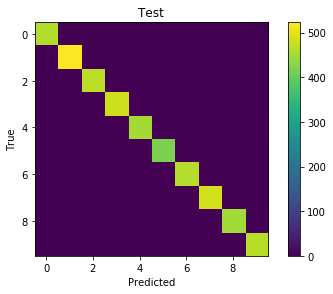

In [19]:
net.eval()
y_test_pred =  net.predict(x_test).data.numpy()
cm_test = confusion_matrix(y_test, y_test_pred)

print(cm_test)
plot_confusion_matrix(cm_test, 'Test')

[[154   0   0   0   0   0   1   0   0   0]
 [  0 175   0   0   1   0   0   0   0   0]
 [  0   0 155   0   0   0   0   2   0   0]
 [  0   0   1 162   0   0   0   0   0   0]
 [  0   0   0   0 153   0   0   0   0   0]
 [  0   0   0   0   0 141   1   0   0   0]
 [  0   0   0   0   0   1 154   0   0   0]
 [  0   0   2   0   0   0   0 163   0   0]
 [  0   0   1   0   0   0   0   0 147   4]
 [  0   0   0   0   1   1   0   0   0 155]]


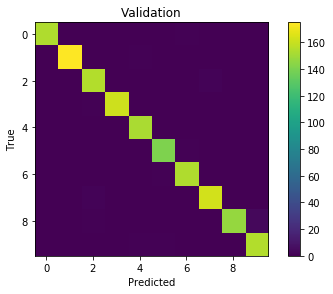

In [20]:
net.eval()
y_val_pred =  net.predict(x_val).data.numpy()
cm_val = confusion_matrix(y_val, y_val_pred)

print(cm_val)
plot_confusion_matrix(cm_val, 'Validation')

In [21]:
net.eval()
y_to_submit = net.predict(x_to_submit)

In [22]:
df_submit = pd.DataFrame()
df_submit['ImageId'] = range(1, y_to_submit.size()[0]+1)
df_submit['Label'] = y_to_submit

In [23]:
df_submit.to_csv('submission.csv', index=False)